# **Maestria en Ciencia de Datos - Universidad Icesi**
## Fundamentos de Analítica de Datos II - Taller 1
### Daniel Martinez Villegas & Luis Felipe Montenegro

# Series temporales simples

In [1]:
import numpy as np
import pandas as pd # Operaciones con dataframes
from matplotlib import pyplot as plt # gráficos
from statsmodels.tsa.seasonal import seasonal_decompose # descomposición de series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # Holwinters simple
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holwinters doble y tripe
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_excel("datosEmpleo.xlsx",index_col='mes',parse_dates=True)
data.head()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120
2001-04-01,17.888575,6973.079,1519.137,4937.280
2001-05-01,17.945654,6994.462,1529.720,4928.911


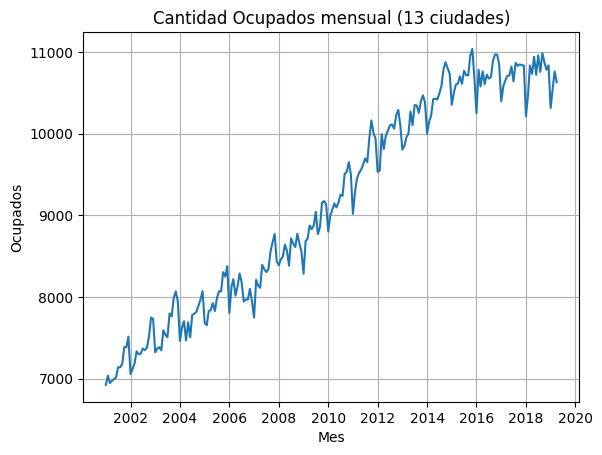

In [3]:
# Graficando los datos
plt.title("Cantidad Ocupados mensual (13 ciudades)")
plt.xlabel("Mes")
plt.ylabel("Ocupados")
plt.plot(data[["Ocupados"]])
plt.grid()
plt.show()

## Evaluation Protocol
### Train-test split

In [4]:
data['year'] = data.index.year
print(data['year'].unique())
print(len(data['year'])) # 220

[2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014
 2015 2016 2017 2018 2019]
220


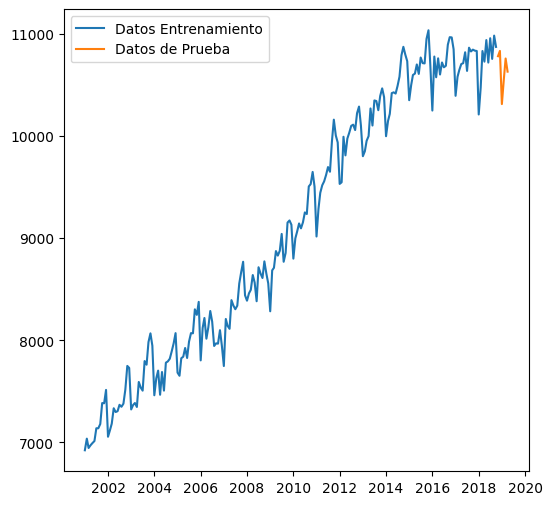

In [5]:
total_data = len(data['year'])
horizon = 6

train_len = total_data - horizon
train_td = data[["Ocupados"]][:train_len]
test_td = data[["Ocupados"]][train_len:]

fig = plt.figure(figsize=(horizon, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(test_td,label="Datos de Prueba")
plt.legend()
plt.show()

## Promedio Movil

- **<font color="red">w</font>** represents the window size, which is the number of data points to consider when calculating the moving average.
- **<font color="red">h</font>** represents the horizon, which is the number of future data points to forecast.

In [6]:
def fore_ma(datos,w,h):
  data=datos.copy()
  for x in range(1,h+1):
    ind = data.index[-1]
    value = ind + pd.DateOffset(months=1)
    data.loc[value]= data[-w:].mean()
  return data[-h:]

In [7]:
movil_avg = [fore_ma(train_td,x,horizon) for x in range(1,25)]

In [8]:
for x in range(len(movil_avg)):
	print(x+1, "------>", np.sqrt(mean_squared_error(test_td,movil_avg[x])))

1 ------> 287.2354279175854
2 ------> 319.1849777906289
3 ------> 298.3770292088787
4 ------> 305.34686253059
5 ------> 291.01606293356485
6 ------> 291.5713004314995
7 ------> 283.4567470273245
8 ------> 279.3491656472429
9 ------> 270.13693523482465
10 ------> 258.0826859664414
11 ------> 245.42326872607504
12 ------> 221.08914545893433
13 ------> 214.50880659854403
14 ------> 213.5825179006286
15 ------> 212.44821683703358
16 ------> 214.88471083985425
17 ------> 218.159032263104
18 ------> 216.56731320777968
19 ------> 216.63618429400097
20 ------> 216.3239820128406
21 ------> 214.08726281143203
22 ------> 212.14619517863974
23 ------> 208.83714957580352
24 ------> 201.65678555054527


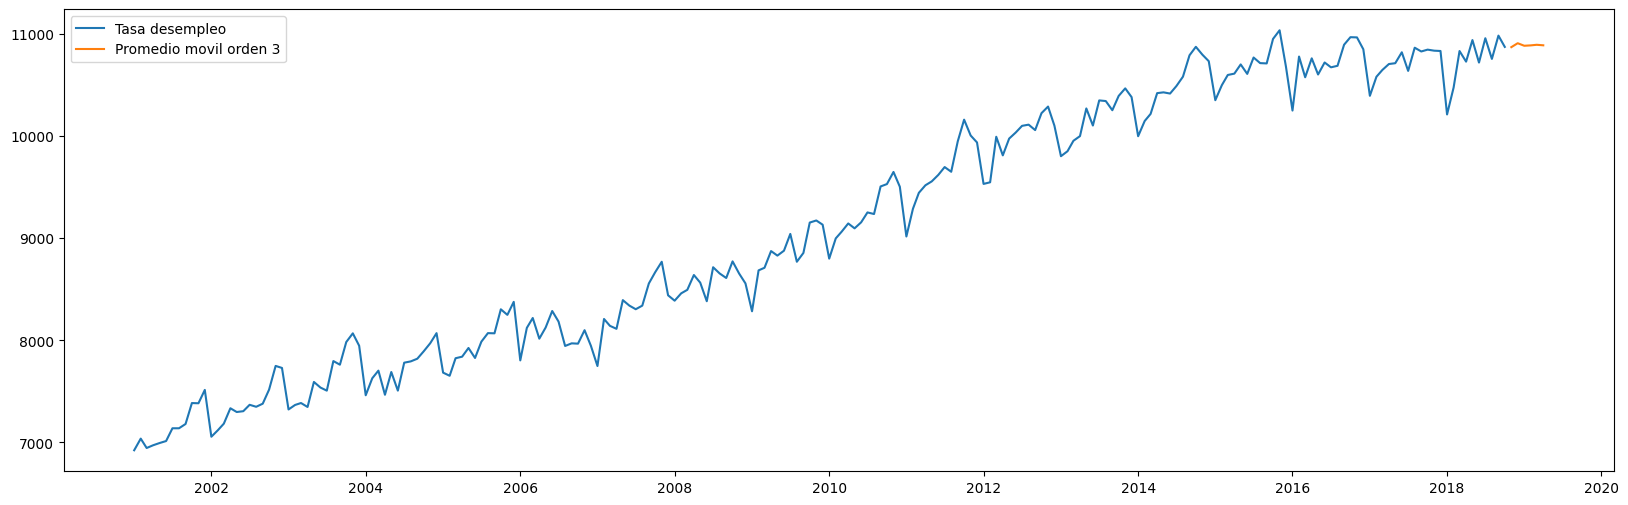

In [9]:
fig = plt.figure(figsize=(20, 6))
plt.plot(train_td,label="Tasa desempleo")
plt.plot(movil_avg[2],label="Promedio movil orden 3")
plt.legend()
plt.show()

- [X] Suavización exponencial simple
- [X] Suavización exponencial lineal Holt
- [X] Suavización exponencial lineal Holt-Winters

In [10]:

# Model
def build_ets_model(train_td, test_td, horizon, error='add', trend=None, seasonal=None):
    # Build model
    ets_model = ETSModel(endog=train_td["Ocupados"], error=error, trend=trend, seasonal=seasonal)
    ets_result = ets_model.fit()

    # Forecast
    point_forecast = ets_result.forecast(horizon)

    # Confidence intervals
    ci = ets_result.get_prediction(start=point_forecast.index[0], end=point_forecast.index[-1])
    conf_forecast = ci.pred_int(alpha=0.05)
    limits = ci.predicted_mean

    # Prepare predictions DataFrame
    preds = pd.concat([limits, conf_forecast], axis=1)
    preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
    print(preds)

    # Plot results
    fig = plt.figure(figsize=(12, 6))
    plt.plot(train_td, label="Datos Entrenamiento")
    plt.plot(preds['Point_forecast'], label="Suavización Exponencial Simple")
    plt.fill_between(preds.index, preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
    plt.legend()
    plt.show()

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test_td, point_forecast))
    print(f"RMSE: {rmse}")

    return {
        "rmse": rmse,
        "alpha": ets_result.alpha,
        "beta": getattr(ets_result, 'beta', None),
        "gamma": getattr(ets_result, 'gamma', None),
        "preds": preds,
	}

## Suavizacion Exponencial Simple

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Point_forecast      lower_95      upper_95
2018-11-01    10890.815856  10535.182689  11246.449022
2018-12-01    10890.815856  10469.673459  11311.958252
2019-01-01    10890.815856  10413.063946  11368.567765
2019-02-01    10890.815856  10362.485602  11419.146109
2019-03-01    10890.815856  10316.343206  11465.288506
2019-04-01    10890.815856  10273.641006  11507.990705


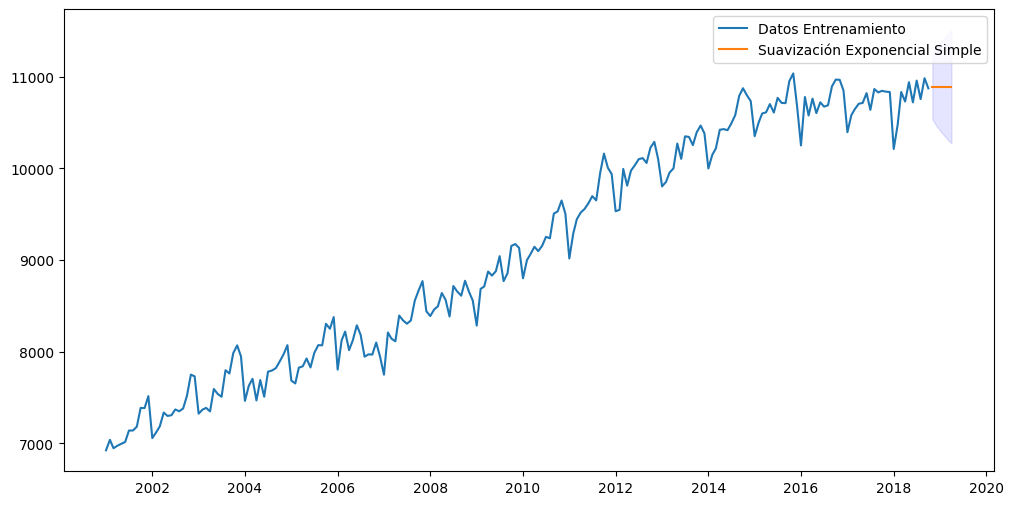

RMSE: 300.4290298412983


In [11]:
suavizacion_exp_simple_add_mse = build_ets_model(train_td, test_td, horizon, error='add')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Point_forecast      lower_95      upper_95
2018-11-01    10890.814949  10464.244718  11304.797092
2018-12-01    10890.814949  10380.809451  11392.512090
2019-01-01    10890.814949  10278.748573  11463.078385
2019-02-01    10890.814949  10241.722351  11497.916098
2019-03-01    10890.814949  10189.526239  11563.594545
2019-04-01    10890.814949  10134.235013  11584.135945


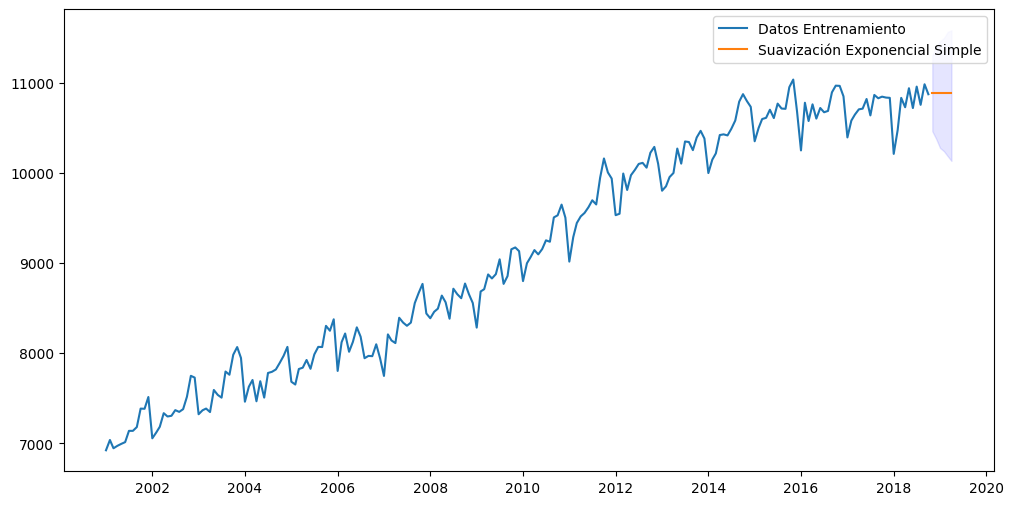

RMSE: 300.4282950082703


In [12]:
suavizacion_exp_simple_mul_mse = build_ets_model(train_td, test_td, horizon, error='mul')

# Suavización Exponencial Lineal (Holt)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Point_forecast      lower_95      upper_95
2018-11-01    10921.837423  10568.380806  11275.294041
2018-12-01    10940.275438  10532.003993  11348.546883
2019-01-01    10958.713453  10501.184691  11416.242215
2019-02-01    10977.151468  10474.277712  11480.025224
2019-03-01    10995.589483  10450.297487  11540.881479
2019-04-01    11014.027498  10428.599401  11599.455595


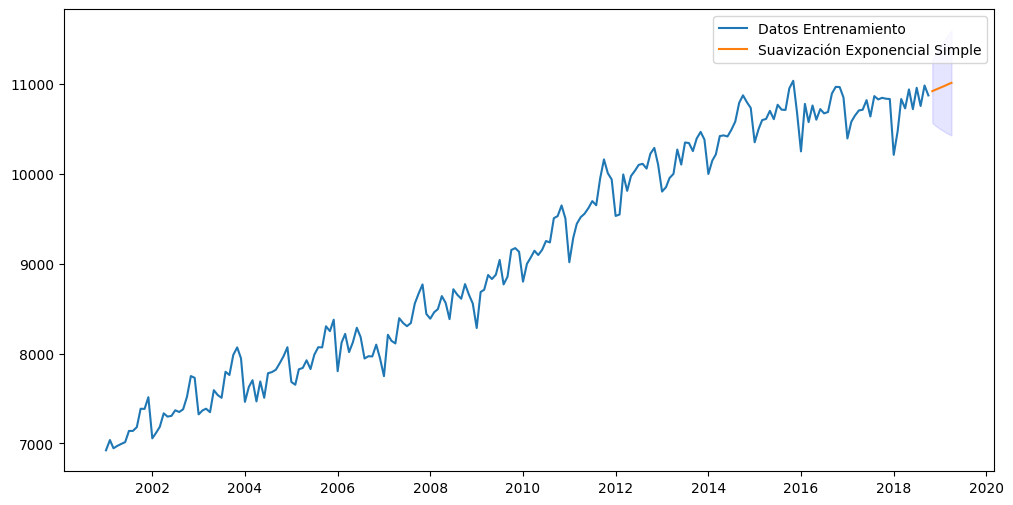

RMSE: 370.1579750635174


In [13]:
suavizacion_exp_lin_holt_add_add_mse = build_ets_model(train_td, test_td, horizon, error='add', trend='add')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Point_forecast      lower_95      upper_95
2018-11-01    10927.114148  10568.117358  11287.435829
2018-12-01    10948.230528  10547.919996  11363.148374
2019-01-01    10969.387716  10503.325162  11401.242699
2019-02-01    10990.585789  10522.504264  11479.264207
2019-03-01    11011.824827  10493.492753  11510.523675
2019-04-01    11033.104908  10498.460692  11548.747724


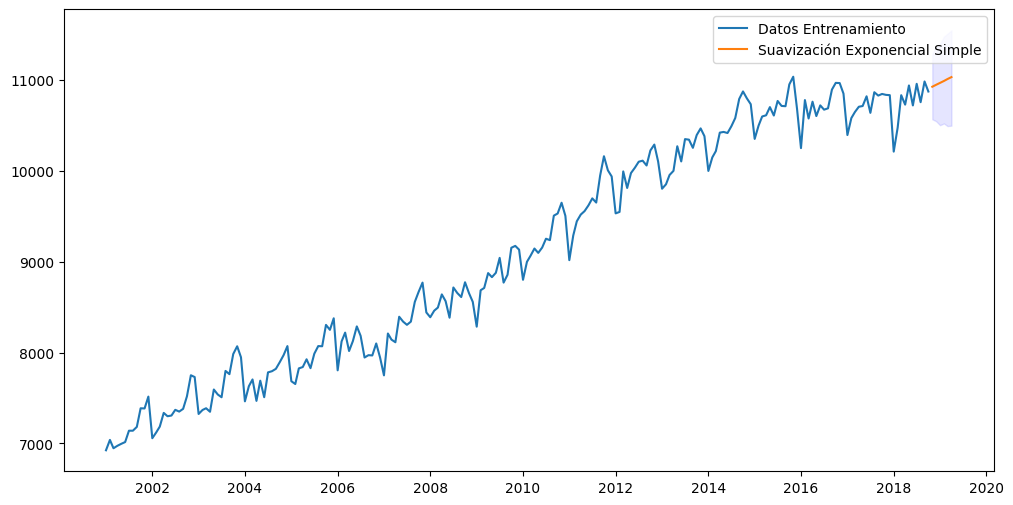

RMSE: 381.54588770018285


In [14]:
suavizacion_exp_lin_holt_add_mul_mse = build_ets_model(train_td, test_td, horizon, error='add', trend='mul')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Point_forecast      lower_95      upper_95
2018-11-01    10927.114148  10601.808696  11250.619328
2018-12-01    10948.230528  10568.695540  11339.042413
2019-01-01    10969.387716  10536.952426  11417.881998
2019-02-01    10990.585789  10536.010010  11468.750979
2019-03-01    11011.824827  10511.440099  11564.257832
2019-04-01    11033.104908  10497.476082  11567.432655


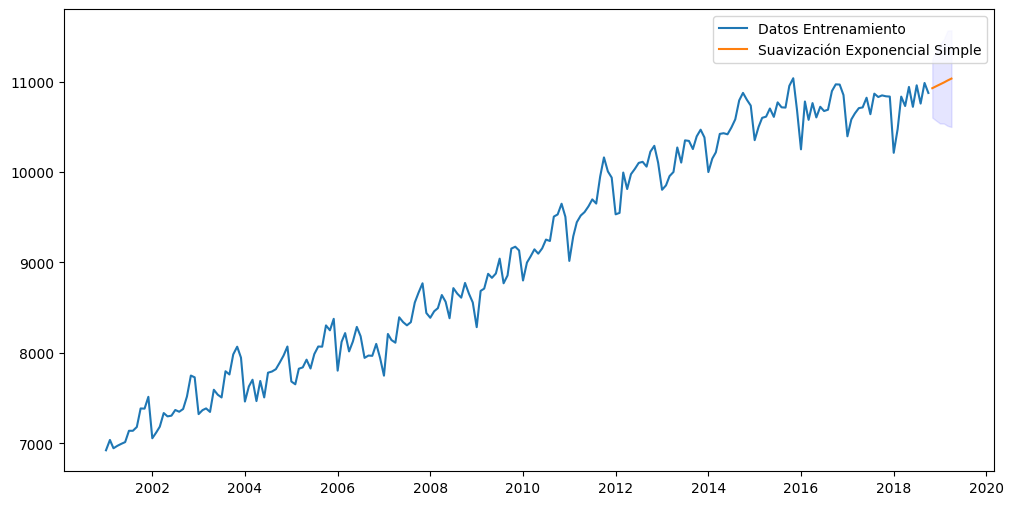

RMSE: 381.54588770018285


In [15]:
suavizacion_exp_lin_holt_mul_mul_mse = build_ets_model(train_td, test_td, horizon, error='add', trend='mul')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Point_forecast      lower_95      upper_95
2018-11-01    10922.345053  10495.554743  11322.527934
2018-12-01    10941.164971  10444.883868  11412.966759
2019-01-01    10959.984890  10419.964059  11473.942701
2019-02-01    10978.804809  10388.027086  11556.554252
2019-03-01    10997.624728  10322.711351  11620.302733
2019-04-01    11016.444647  10316.590987  11717.302760


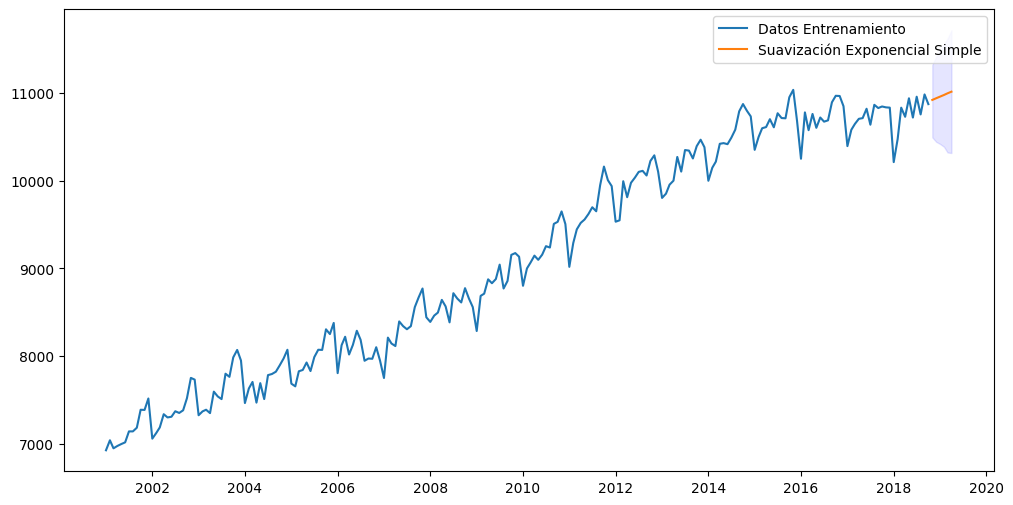

RMSE: 371.54436053379465


In [16]:
suavizacion_exp_lin_holt_mul_add_mse = build_ets_model(train_td, test_td, horizon, error='mul', trend='add')

# Suavización Exponencial Lineal de Winters (Holt-Winters)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Point_forecast      lower_95      upper_95
2018-11-01    11016.615370  10758.765337  11274.465403
2018-12-01    10910.345328  10638.016873  11182.673784
2019-01-01    10431.804223  10145.726486  10717.881959
2019-02-01    10707.064097  10407.865684  11006.262509
2019-03-01    10853.107263  10541.337405  11164.877121
2019-04-01    10868.686776  10544.830737  11192.542816


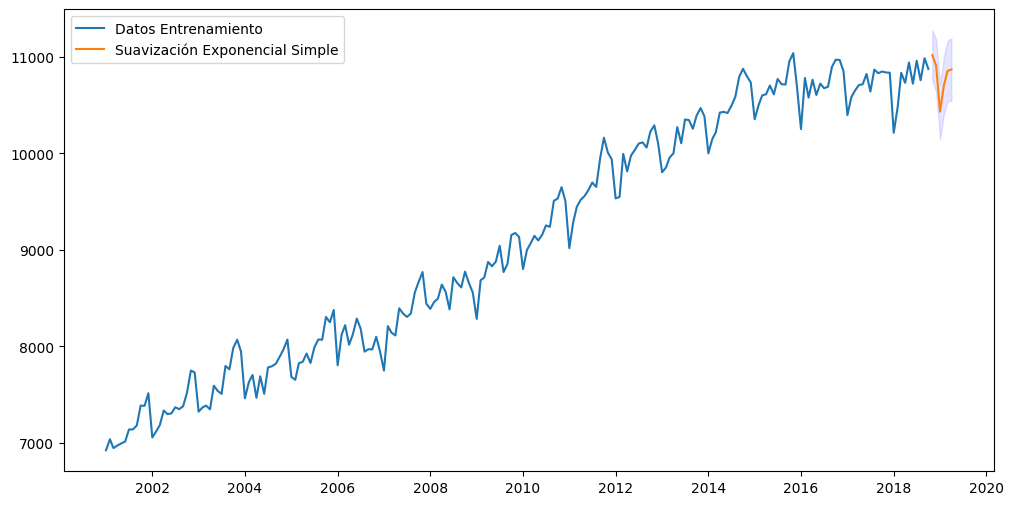

RMSE: 163.6081475588887


In [17]:
suavizacion_exp_lin_holt_winters_add_add_add_mse = build_ets_model(train_td, test_td, horizon, error='add', trend='add', seasonal='add')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Point_forecast      lower_95      upper_95
2018-11-01    11033.314201  10745.375090  11298.025012
2018-12-01    10941.667798  10628.164994  11268.005370
2019-01-01    10481.956092  10148.392835  10805.996446
2019-02-01    10698.260889  10318.868849  11078.990850
2019-03-01    10791.000570  10392.957022  11204.690499
2019-04-01    10811.523619  10393.992564  11244.661472


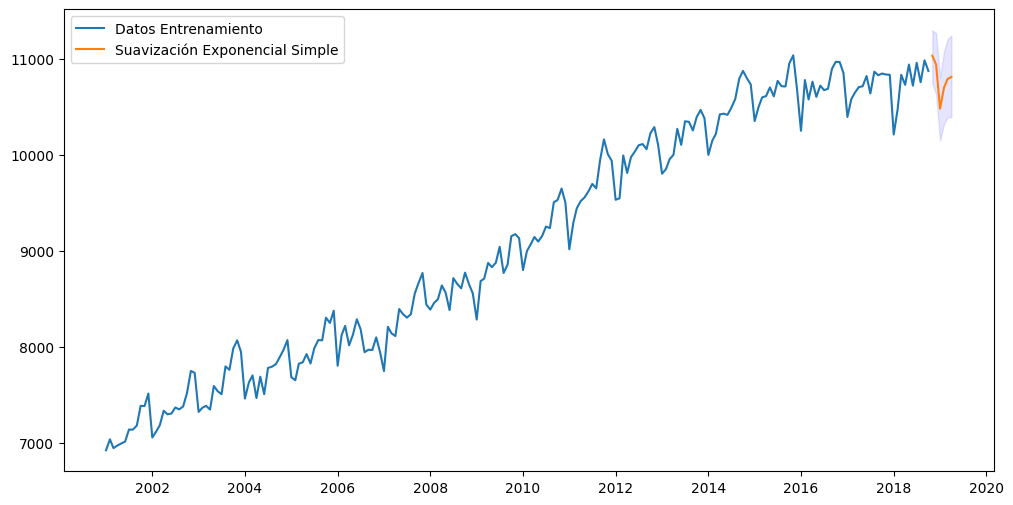

RMSE: 160.56763429342286


In [18]:
suavizacion_exp_lin_holt_winters_mul_mul_mul_mse = build_ets_model(train_td, test_td, horizon, error='mul', trend='mul', seasonal='mul')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Point_forecast      lower_95      upper_95
2018-11-01    11020.412574  10682.089945  11365.090619
2018-12-01    10918.631490  10583.678982  11271.840261
2019-01-01    10430.597045  10066.757909  10806.838204
2019-02-01    10709.637041  10319.300147  11077.954524
2019-03-01    10860.927613  10466.943594  11261.091712
2019-04-01    10869.560918  10475.711904  11281.063121


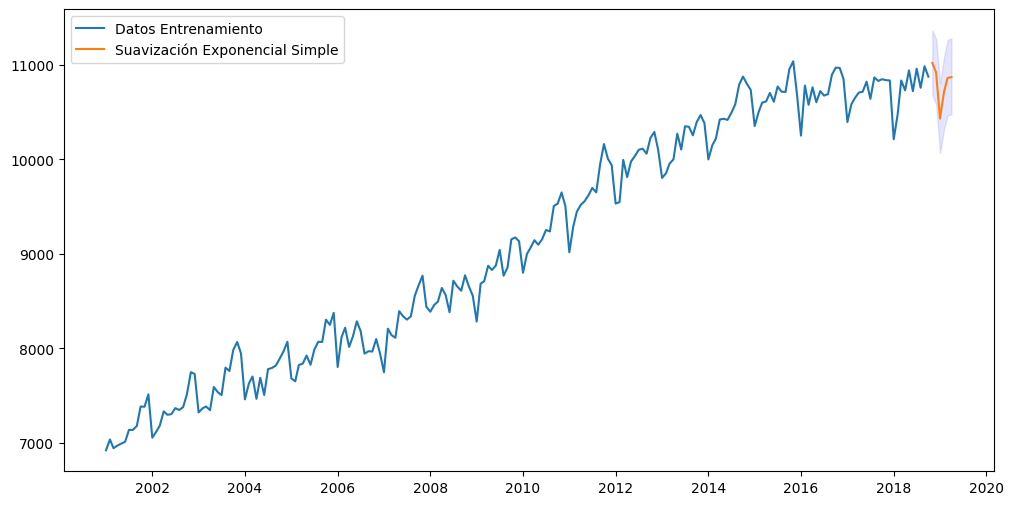

RMSE: 166.39049859272805


In [19]:
suavizacion_exp_lin_holt_winters_mul_add_add_mse = build_ets_model(train_td, test_td, horizon, error='mul', trend='add', seasonal='add')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Point_forecast      lower_95      upper_95
2018-11-01    11052.042881  10691.720340  11472.922287
2018-12-01    10976.359576  10557.310188  11405.754579
2019-01-01    10464.205848  10024.924884  10887.874364
2019-02-01    10753.075830  10351.276726  11194.546482
2019-03-01    10932.161752  10488.035770  11422.547614
2019-04-01    10913.766433  10441.769343  11435.991247


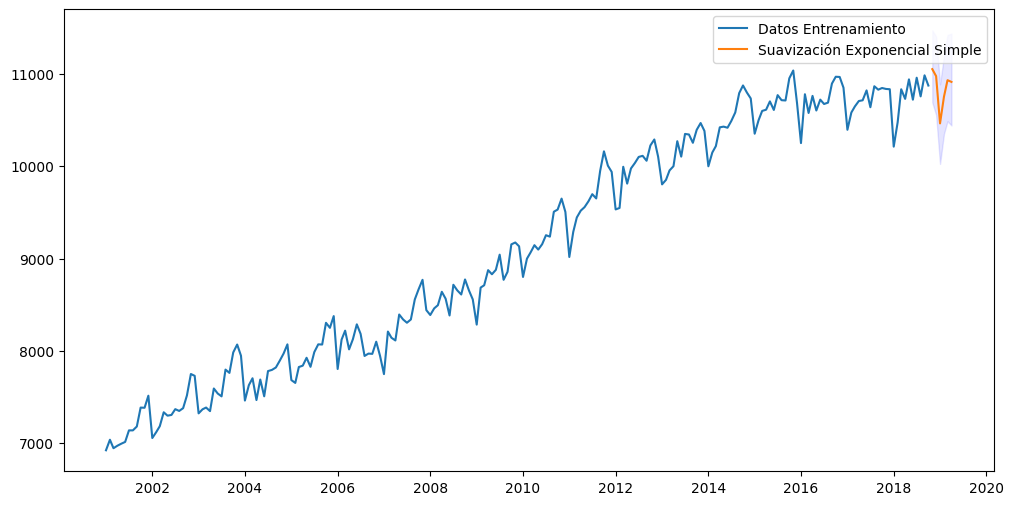

RMSE: 208.7105001239104


In [20]:
suavizacion_exp_lin_holt_winters_mul_mul_add_mse = build_ets_model(train_td, test_td, horizon, error='mul', trend='mul', seasonal='add')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Point_forecast      lower_95      upper_95
2018-11-01    11021.454009  10698.663118  11341.163994
2018-12-01    10923.952572  10605.105126  11236.364424
2019-01-01    10430.847684  10118.152157  10766.084183
2019-02-01    10714.866687  10350.308152  11072.505606
2019-03-01    10869.083615  10495.514318  11258.534893
2019-04-01    10871.565260  10491.425589  11266.350183


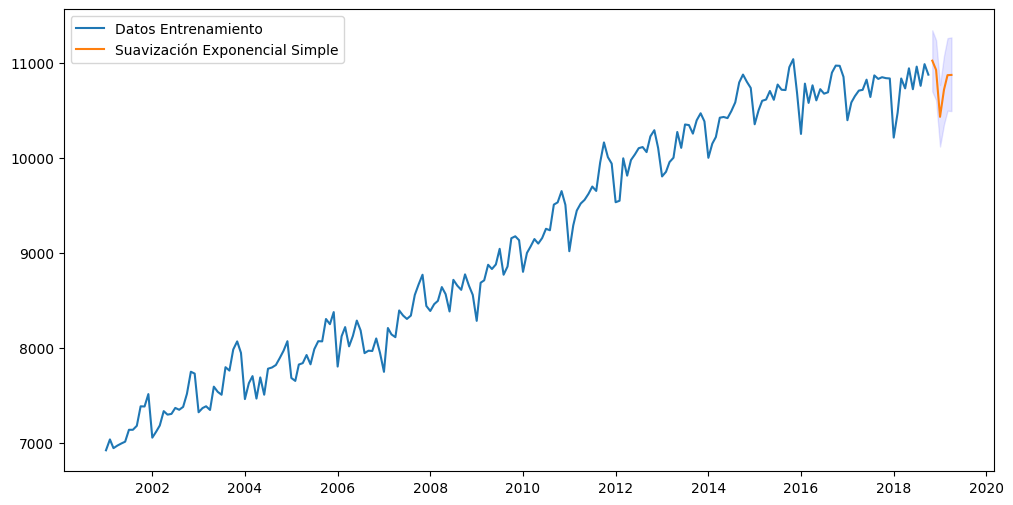

RMSE: 169.2398581225239


In [21]:
suavizacion_exp_lin_holt_winters_add_mul_add_mse = build_ets_model(train_td, test_td, horizon, error='add', trend='mul', seasonal='add')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Point_forecast      lower_95      upper_95
2018-11-01    11027.470105  10798.874263  11255.771614
2018-12-01    10921.685157  10660.819998  11195.552852
2019-01-01    10472.005916  10194.495079  10753.531830
2019-02-01    10691.000571  10391.511945  11000.272826
2019-03-01    10793.959412  10470.574174  11117.200920
2019-04-01    10821.997308  10478.932642  11177.612142


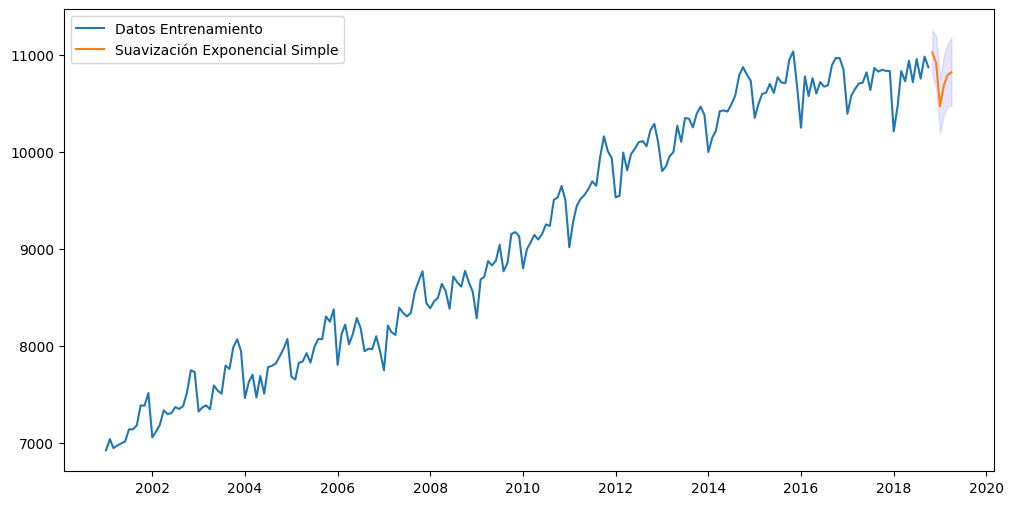

RMSE: 156.41470708036718


In [22]:
suavizacion_exp_lin_holt_winters_add_add_mul_mse = build_ets_model(train_td, test_td, horizon, error='add', trend='add', seasonal='mul')

# Revisión y Elección del Mejor Modelo

In [23]:
mse_list = {
	"suavizacion_exp_lin_holt_winters_add_add_mul_mse": suavizacion_exp_lin_holt_winters_add_add_mul_mse,
	"suavizacion_exp_lin_holt_winters_add_mul_add_mse": suavizacion_exp_lin_holt_winters_add_mul_add_mse,
	"suavizacion_exp_lin_holt_winters_mul_mul_add_mse": suavizacion_exp_lin_holt_winters_mul_mul_add_mse,
	"suavizacion_exp_lin_holt_winters_mul_add_add_mse": suavizacion_exp_lin_holt_winters_mul_add_add_mse,
	"suavizacion_exp_lin_holt_winters_mul_mul_mul_mse": suavizacion_exp_lin_holt_winters_mul_mul_mul_mse,
	"suavizacion_exp_lin_holt_winters_add_add_add_mse": suavizacion_exp_lin_holt_winters_add_add_add_mse,
	"suavizacion_exp_lin_holt_mul_add_mse": suavizacion_exp_lin_holt_mul_add_mse,
	"suavizacion_exp_lin_holt_mul_mul_mse": suavizacion_exp_lin_holt_mul_mul_mse,
	"suavizacion_exp_lin_holt_add_mul_mse": suavizacion_exp_lin_holt_add_mul_mse,
	"suavizacion_exp_lin_holt_add_add_mse": suavizacion_exp_lin_holt_add_add_mse,
	"suavizacion_exp_simple_mul_mse": suavizacion_exp_simple_mul_mse,
	"suavizacion_exp_simple_add_mse": suavizacion_exp_simple_add_mse,
}


sorted_mse_list = dict(sorted(mse_list.items(), key=lambda item: item[1]['rmse']))
for key, value in sorted_mse_list.items():
	print(key)
	print("RMSE:", value['rmse'])
	print("Alpha:", value['alpha'])
	print("Beta:", value['beta'])
	print("Gamma:", value['gamma'])
	print("-----------------------")

suavizacion_exp_lin_holt_winters_add_add_mul_mse
RMSE: 156.41470708036718
Alpha: 0.5133662616515942
Beta: 0.0013157804729060712
Gamma: 4.8663373834840584e-05
-----------------------
suavizacion_exp_lin_holt_winters_mul_mul_mul_mse
RMSE: 160.56763429342286
Alpha: 0.5465853506695763
Beta: 5.465853506695763e-05
Gamma: 4.5341464933042375e-05
-----------------------
suavizacion_exp_lin_holt_winters_add_add_add_mse
RMSE: 163.6081475588887
Alpha: 0.3397512482944894
Beta: 3.397512482944894e-05
Gamma: 0.3013646393190514
-----------------------
suavizacion_exp_lin_holt_winters_mul_add_add_mse
RMSE: 166.39049859272805
Alpha: 0.34897040496600673
Beta: 3.4897040496600676e-05
Gamma: 0.3261391871755503
-----------------------
suavizacion_exp_lin_holt_winters_add_mul_add_mse
RMSE: 169.2398581225239
Alpha: 0.3887356892308206
Beta: 3.887356892308206e-05
Gamma: 0.3372490744906431
-----------------------
suavizacion_exp_lin_holt_winters_mul_mul_add_mse
RMSE: 208.7105001239104
Alpha: 0.3063305159163973
Bet

In [30]:
# Definimos el diccionario con los valores de MSE
mse_list = {
    "suavizacion_exp_lin_holt_winters_add_add_mul_mse": suavizacion_exp_lin_holt_winters_add_add_mul_mse,
    "suavizacion_exp_lin_holt_winters_add_mul_add_mse": suavizacion_exp_lin_holt_winters_add_mul_add_mse,
    "suavizacion_exp_lin_holt_winters_mul_mul_add_mse": suavizacion_exp_lin_holt_winters_mul_mul_add_mse,
    "suavizacion_exp_lin_holt_winters_mul_add_add_mse": suavizacion_exp_lin_holt_winters_mul_add_add_mse,
    "suavizacion_exp_lin_holt_winters_mul_mul_mul_mse": suavizacion_exp_lin_holt_winters_mul_mul_mul_mse,
    "suavizacion_exp_lin_holt_winters_add_add_add_mse": suavizacion_exp_lin_holt_winters_add_add_add_mse,
    "suavizacion_exp_lin_holt_mul_add_mse": suavizacion_exp_lin_holt_mul_add_mse,
    "suavizacion_exp_lin_holt_mul_mul_mse": suavizacion_exp_lin_holt_mul_mul_mse,
    "suavizacion_exp_lin_holt_add_mul_mse": suavizacion_exp_lin_holt_add_mul_mse,
    "suavizacion_exp_lin_holt_add_add_mse": suavizacion_exp_lin_holt_add_add_mse,
    "suavizacion_exp_simple_mul_mse": suavizacion_exp_simple_mul_mse,
    "suavizacion_exp_simple_add_mse": suavizacion_exp_simple_add_mse,
}

# Ordenamos los modelos según el RMSE

sorted_mse_list = dict(sorted(mse_list.items(), key=lambda item: item[1]['rmse']))

# Creamos una lista de diccionarios para crear el DataFrame

data = [{"Modelo": key, "RMSE": value['rmse']} for key, value in sorted_mse_list.items()]

# Convertimos la lista de diccionarios en un DataFrame de pandas

df = pd.DataFrame(data)

# Establecer el índice como el nombre del modelo (opcional, solo para esconder el índice numérico original)

df = df.set_index("Modelo")

# Resaltar el RMSE más bajo

def highlight_min(s):
    is_min = s == s.min()
    return ['background-color: lightgreen' if v else '' for v in is_min]

#Estilo

styled_df = df.style.apply(highlight_min, subset=['RMSE']).set_table_styles(
    [{'selector': 'th', 'props': [('border', '1px solid black')]},
     {'selector': 'td', 'props': [('border', '1px solid black')]}]
).set_properties(**{'text-align': 'center'})

styled_df

,RMSE
Modelo,
suavizacion_exp_lin_holt_winters_add_add_mul_mse,156.414707
suavizacion_exp_lin_holt_winters_mul_mul_mul_mse,160.567634
suavizacion_exp_lin_holt_winters_add_add_add_mse,163.608148
suavizacion_exp_lin_holt_winters_mul_add_add_mse,166.390499
suavizacion_exp_lin_holt_winters_add_mul_add_mse,169.239858
suavizacion_exp_lin_holt_winters_mul_mul_add_mse,208.710500
suavizacion_exp_simple_mul_mse,300.428295
suavizacion_exp_simple_add_mse,300.429030
suavizacion_exp_lin_holt_add_add_mse,370.157975


In [24]:
suavizacion_exp_lin_holt_winters_add_add_mul_mse['preds']

,Point_forecast,lower_95,upper_95
2018-11-01,11027.470105,10798.874263,11255.771614
2018-12-01,10921.685157,10660.819998,11195.552852
2019-01-01,10472.005916,10194.495079,10753.531830
2019-02-01,10691.000571,10391.511945,11000.272826
2019-03-01,10793.959412,10470.574174,11117.200920
2019-04-01,10821.997308,10478.932642,11177.612142


# Usar Alpha, Beta y Gamma

In [25]:
## Ahora se ajusta el modelo final con todos los datos

final_model = ETSModel(endog=data["Ocupados"],error="add",trend="add",seasonal="mul")
final_model_fit = final_model.fit_constrained({'smoothing_level': 0.5133659457086996,'smoothing_trend': 0.0013157803999827881,'smoothing_seasonal':4.866340542913004e-05})

print("alpha: ", final_model_fit.alpha)
print("beta: ", final_model_fit.beta)
print("gamma: ", final_model_fit.gamma)

alpha:  0.5133659457086996
beta:  0.0013157803999827881
gamma:  4.866340542913004e-05


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


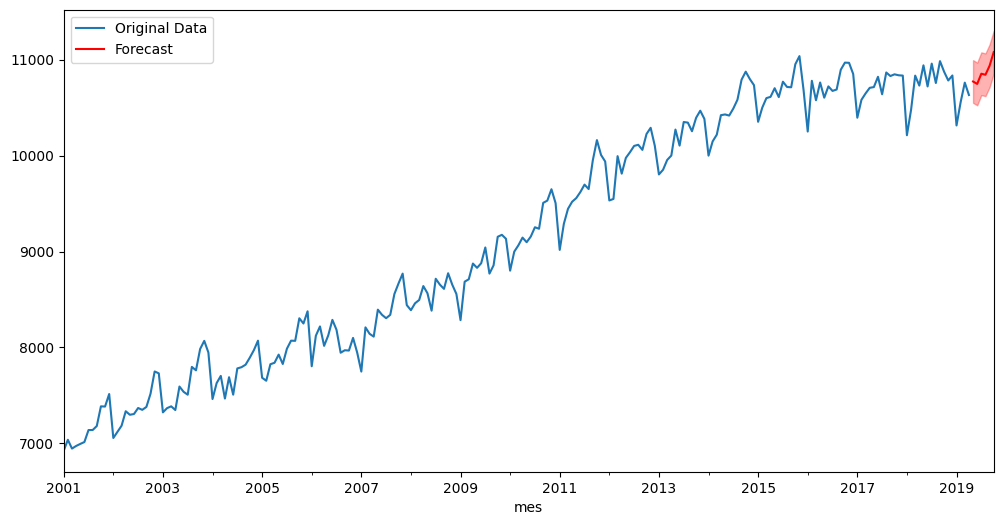

In [26]:

forecast = final_model_fit.forecast(horizon)
fig, ax = plt.subplots(figsize=(12, 6))
data["Ocupados"].plot(ax=ax, label="Original Data")
forecast.plot(ax=ax, label="Forecast", color='red')
plt.fill_between(forecast.index, forecast - 1.96 * final_model_fit.resid.std(), forecast + 1.96 * final_model_fit.resid.std(), color='red', alpha=0.3)
plt.legend()
plt.show()

In [27]:
# Confidence intervals
ci = final_model_fit.get_prediction(start=forecast.index[0], end=forecast.index[-1])
conf_forecast = ci.pred_int(alpha=0.05)
limits = ci.predicted_mean

preds_holt = pd.concat([limits, conf_forecast], axis=1)
preds_holt.columns = ['Point_forecast', 'lower_95', 'upper_95']
preds_holt

,Point_forecast,lower_95,upper_95
2019-05-01,10772.637904,10547.849944,10972.776011
2019-06-01,10747.213943,10513.256674,10995.217142
2019-07-01,10853.759047,10576.236125,11131.321802
2019-08-01,10842.999845,10547.944334,11133.476429
2019-09-01,10936.731112,10603.521965,11251.860335
2019-10-01,11079.324058,10737.574795,11416.984862
